In [1]:
using PyPlot, Printf, DelimitedFiles, Statistics
using CuArrays;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /opt/julia_depot/packages/Revise/C272c/src/Revise.jl:1219


In [2]:
KBT = KB_kcalpermol*300.0;
K = 16;
spring_constant = 50.0;

In [3]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/string_alad/10_crd_convert/umb.%d.dat" k
  x = readdlm(filename);
  push!(data_k, x)
end

filename = @sprintf "data/string_alad/10_crd_convert/umb_center.dat"
x = readdlm(filename);
umbrella_center =  x;

In [4]:
gpu_data_k = CuArray.(data_k);
gpu_umbrella_center = CuArray(umbrella_center);

In [5]:
gpu_data_k

16-element Array{CuArray{Float64,2,Nothing},1}:
 [2.332852 2.942286 … 7.59611 1.034719; 2.36353 2.972174 … 7.667831 1.026357; … ; 2.372051 2.987363 … 7.629243 0.99575; 2.278793 3.086819 … 7.632063 1.128406]
 [2.409006 2.664714 … 7.767018 0.90018; 2.39944 2.828521 … 7.756751 0.954941; … ; 2.384777 2.796549 … 7.7285 0.819207; 2.354989 2.809393 … 7.622541 0.978752]
 [2.421438 2.830805 … 7.788936 0.929436; 2.398136 2.761383 … 7.783452 0.859076; … ; 2.370786 2.745588 … 7.766314 0.769158; 2.425431 2.914995 … 7.716807 0.820573]
 [2.474261 2.82763 … 7.773695 0.889101; 2.428653 2.808746 … 7.824356 0.822904; … ; 2.482903 2.718624 … 7.816466 0.812754; 2.457599 2.74526 … 7.858467 0.789756]
 [2.466845 2.81374 … 7.887015 0.589133; 2.501799 2.773517 … 7.847926 0.745526; … ; 2.497062 2.884988 … 7.844658 0.73095; 2.554727 2.800342 … 7.857785 0.837552]
 [2.544888 2.744713 … 7.848381 0.753067; 2.558321 2.730158 … 7.795389 0.791404; … ; 2.511749 2.772269 … 7.830086 0.76363; 2.570823 2.792044 … 7.814648 0.

# delta pmf between the umbrella snapshots and the 1st snapshot

In [6]:
CuArrays.@time delta_pmf = sp_delta_pmf(gpu_umbrella_center, gpu_data_k, KBT, spring_constant);

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /opt/julia_depot/packages/GPUArrays/QDGmr/src/host/indexing.jl:43


 13.488066 seconds (24.86 M CPU allocations: 1.226 GiB, 3.14% gc time) (322 GPU allocations: 23.112 MiB, 0.52% gc time of which 48.94% spent allocating)


# design matrix for linear regression

delta_pmf = M * weight

In [18]:
sigma_rdf = 2.0;
CuArrays.@time M = sp_design_matrix(gpu_umbrella_center, gpu_data_k, sigma_rdf);

  0.184712 seconds (222.78 k CPU allocations: 7.251 MiB) (2.05 k GPU allocations: 74.135 MiB, 43.54% gc time of which 95.29% spent allocating)


# lasso

Solve weights for 

delta_pmf = M * weight

In [19]:
M_standardized, mean_M, std_M = sp_standardize(M);
delta_pmf_vector = delta_pmf[:] .- mean(delta_pmf);

In [24]:
lambda = 1.0;
CuArrays.@time weight = sp_admm(delta_pmf_vector, M_standardized, lambda);

1 = 1
1.1 = 1.1
1.2 = 1.2
1.3 = 1.3
2 = 2
3 = 3
[ Cycle Count = 102 ]
[ Complete Condition ]
  Max Differ = 9.547677962018497e-6


  0.051971 seconds (65.32 k CPU allocations: 2.245 MiB) (426 GPU allocations: 90.043 KiB, 12.30% gc time of which 88.00% spent allocating)


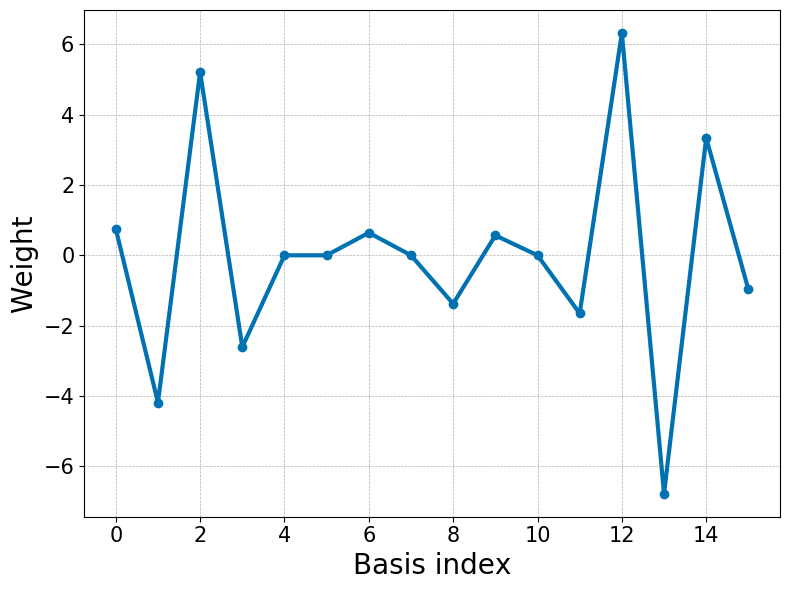

In [25]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(weight[:], linewidth=3, "-o")
xlabel("Basis index",fontsize=20)
ylabel("Weight",fontsize=20)

#ax.set(xlim=[-1, 60], ylim=[-0.3, 0.3])
ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_weight.png", dpi=350)

# cumulate PMF

In [26]:
pmf = sp_cumulate_pmf(umbrella_center, weight, umbrella_center, sigma_rdf, mean_M, std_M)

16-element Array{Float64,1}:
  1.173200755123947
  0.0
  3.515772491647258
  6.376369535697059
  8.997662881235742
 10.962069189631123
 12.486530172194406
 13.489540790176036
 14.45569415442011
 16.145924176355287
 16.749996794317568
 15.75827247621244
 12.680996710975457
  9.155619281156874
  7.016790011948437
  5.934720855261368

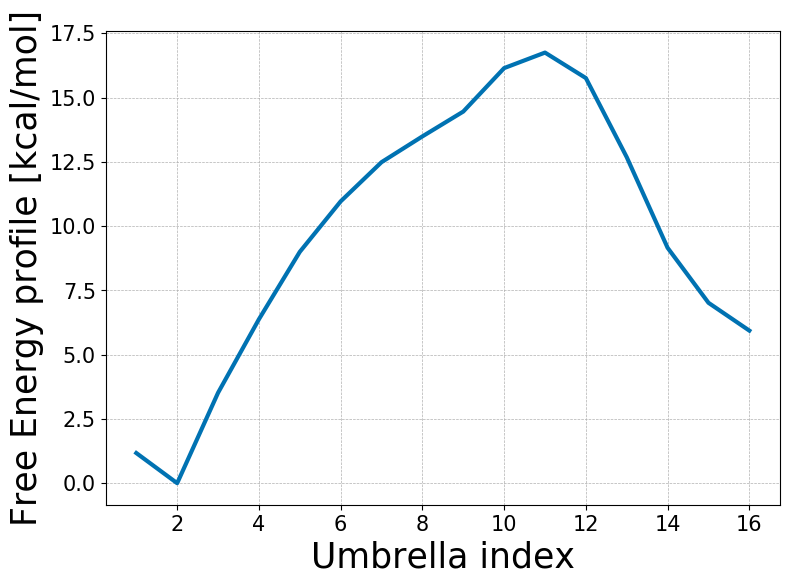

In [27]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(1:K, pmf, linewidth=3)
xlabel("Umbrella index",fontsize=25)
ylabel("Free Energy profile [kcal/mol]",fontsize=25)

ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_pmf..png", dpi=350)